In [34]:
import matplotlib.pyplot as plt
import re
import ast
import sys

# Define a simple class to hold request metrics
class RequestMetrics:
    def __init__(self, arrival_time, last_token_time, first_scheduled_time, first_token_time, time_in_queue, finished_time, scheduler_time, model_forward_time, model_execute_time, spec_token_acceptance_counts):
        self.arrival_time = arrival_time
        self.last_token_time = last_token_time
        self.first_scheduled_time = first_scheduled_time
        self.first_token_time = first_token_time
        self.time_in_queue = time_in_queue
        self.finished_time = finished_time
        self.scheduler_time = scheduler_time
        self.model_forward_time = model_forward_time
        self.model_execute_time = model_execute_time
        self.spec_token_acceptance_counts = spec_token_acceptance_counts

# Function to parse the log file and extract RequestMetrics and other metrics
def parse_log_file(log_file_path):
    with open(log_file_path, 'r') as f:
        log_content = f.read()
    
    # Extract RequestMetrics
    request_metrics = []
    req_pattern = r'RequestMetrics\((.*?)\)'
    for match in re.finditer(req_pattern, log_content, re.DOTALL):
        content = match.group(1)
        params = {}
        # Split by ', ' but handle lists and None
        parts = re.split(r',\s*(?=[a-z_]+=)', content)
        for part in parts:
            if '=' in part:
                key, value = part.split('=', 1)
                key = key.strip()
                value = value.strip()
                try:
                    params[key] = ast.literal_eval(value)
                except:
                    params[key] = None if value == 'None' else value
        if all(k in params for k in ['arrival_time', 'last_token_time', 'first_scheduled_time', 'first_token_time', 'time_in_queue', 'finished_time', 'scheduler_time', 'model_forward_time', 'model_execute_time', 'spec_token_acceptance_counts']):
            req = RequestMetrics(
                params['arrival_time'], params['last_token_time'], params['first_scheduled_time'],
                params['first_token_time'], params['time_in_queue'], params['finished_time'],
                params['scheduler_time'], params['model_forward_time'], params['model_execute_time'],
                params['spec_token_acceptance_counts']
            )
            request_metrics.append(req)
    
    return request_metrics

def draw_file(file):
    _base_dir = "vllm_tp_logs/"
    log_file_path = _base_dir + file
    # Parse the log
    requests = parse_log_file(log_file_path)
    
    # Find the earliest arrival time as reference point
    t0 = min([req.arrival_time for req in requests]) if requests else 0
    
    # Create the Gantt chart
    fig, ax = plt.subplots(figsize=(15, 10))
    
    for i, req in enumerate(requests):
        # Calculate relative times for each phase
        queue_start = req.arrival_time - t0
        queue_duration = req.first_scheduled_time - req.arrival_time
        prep_start = req.first_scheduled_time - t0
        if req.first_token_time is None:
            req.first_token_time = req.first_scheduled_time
        prep_duration = req.first_token_time - req.first_scheduled_time
        proc_start = req.first_token_time - t0
        proc_duration = req.finished_time - req.first_token_time
        
        # Plot bars for queueing, preparation, and processing phases
        ax.barh(i, queue_duration, left=queue_start, color='gray', label='Pending' if i == 0 else "")
        ax.barh(i, prep_duration, left=prep_start, color='blue', label='Prefill' if i == 0 else "")
        ax.barh(i, proc_duration, left=proc_start, color='green', label='Decode' if i == 0 else "")
    
    # Customize the plot
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Request ID')
    ax.set_yticks(range(len(requests)))
    ax.set_yticklabels([f'Req {i+1}' for i in range(len(requests))])
    ax.set_title(file)
    max_duration = max([req.finished_time - t0 for req in requests]) if requests else 100
    ax.set_xlim(0, max_duration + 50)  # Dynamic x-axis limit
    ax.legend()
    plt.tight_layout()
    plt.show()



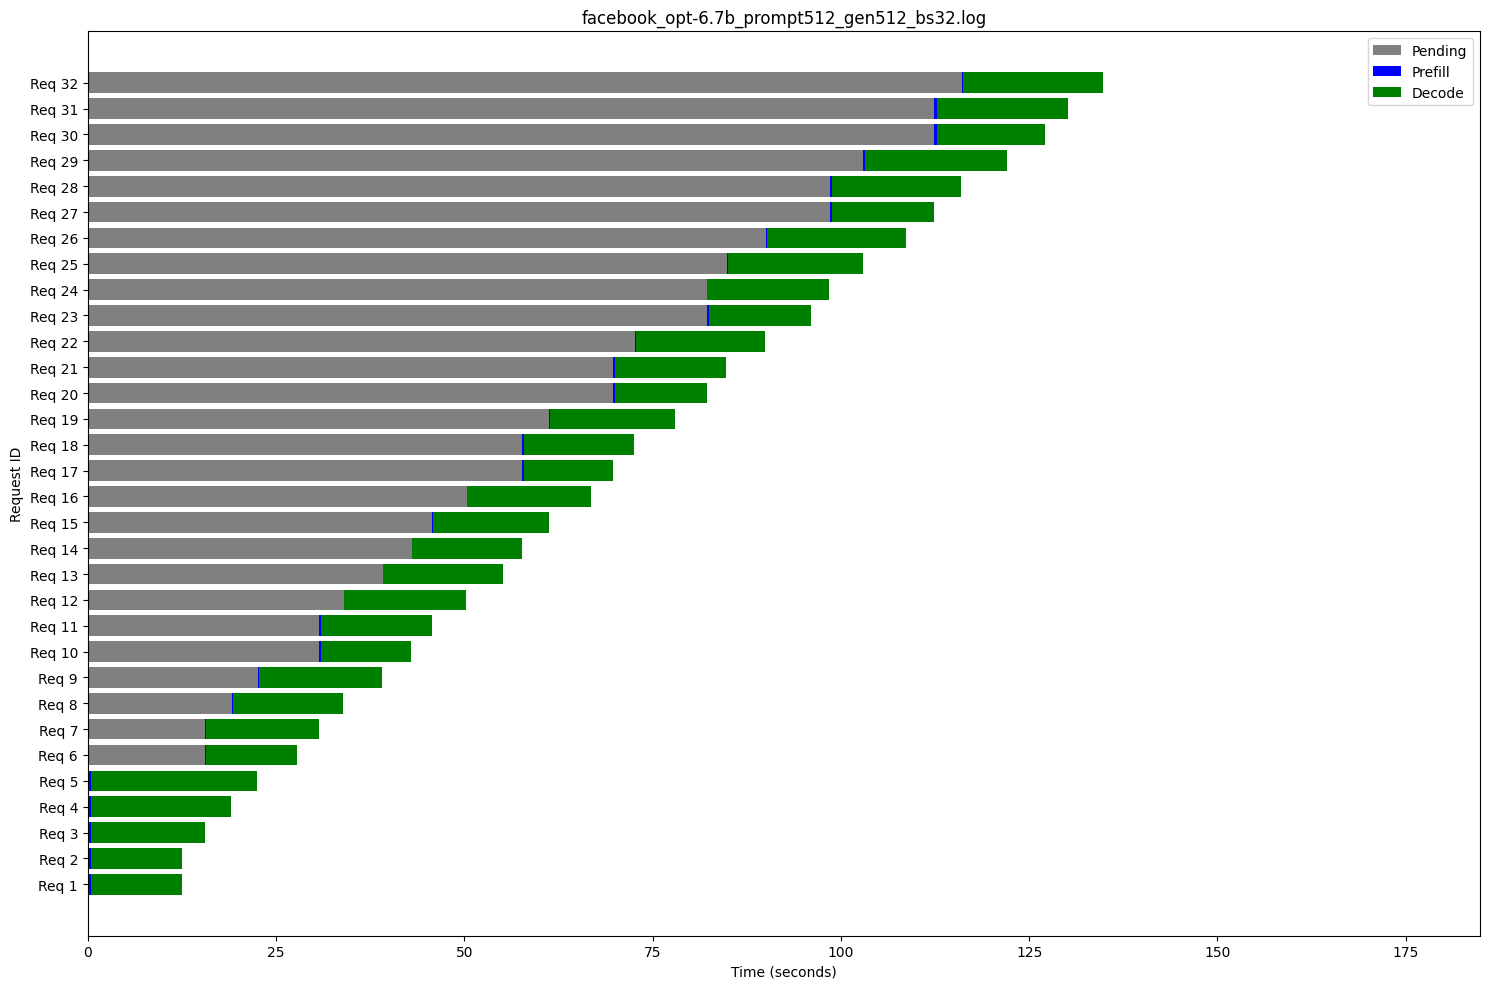

In [35]:
file = "facebook_opt-6.7b_prompt512_gen512_bs32.log"
draw_file(file)

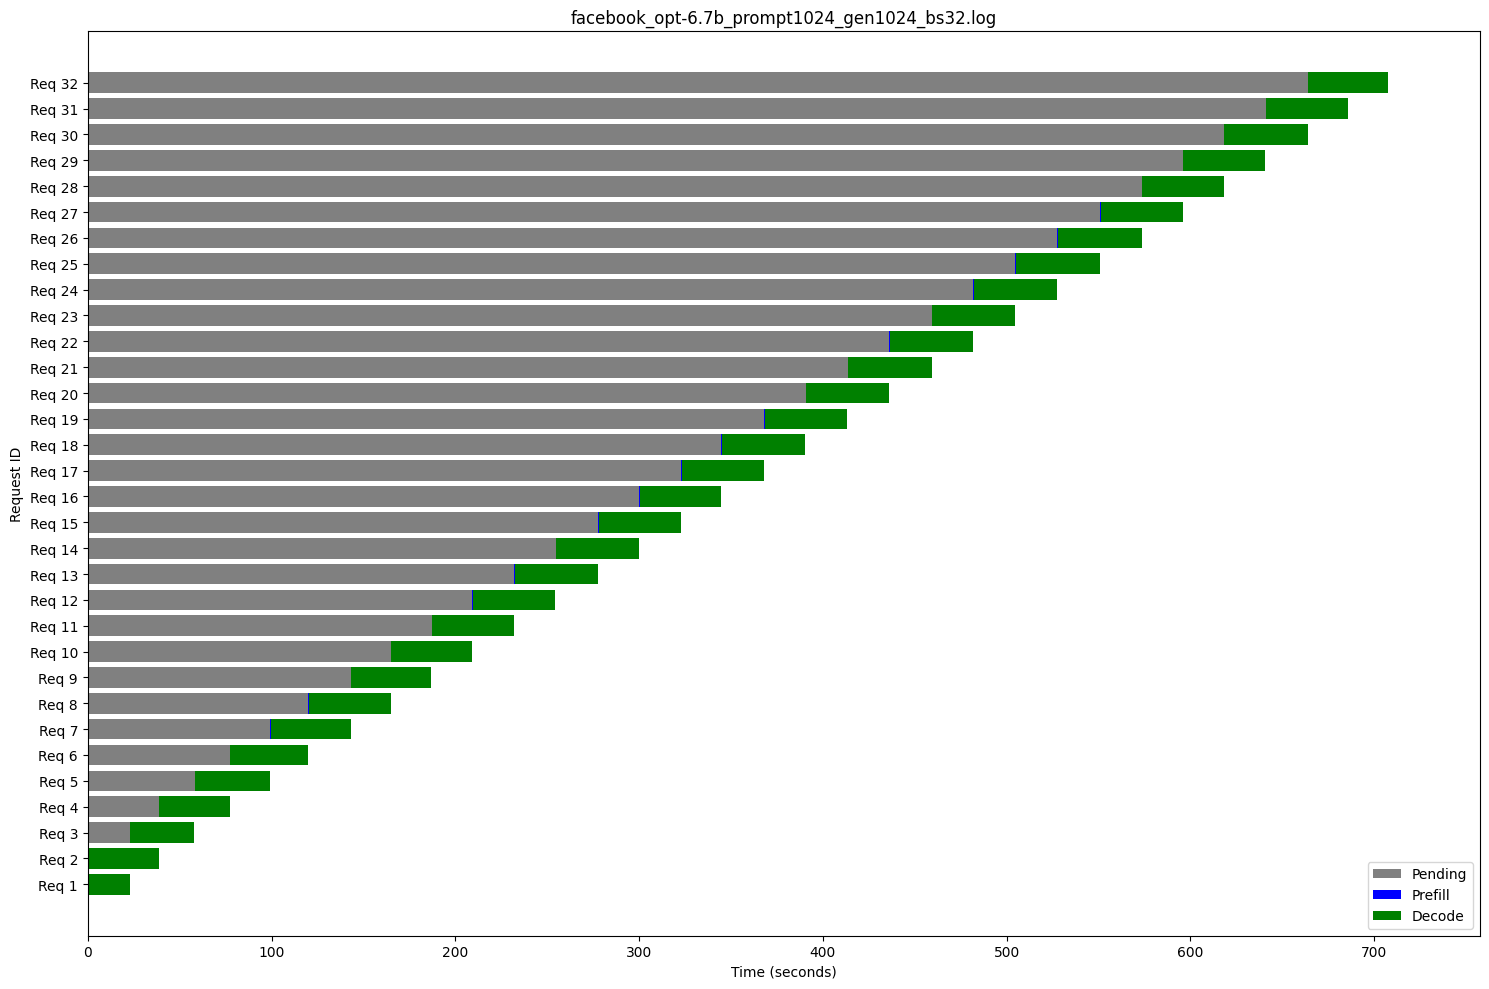

In [36]:
file = "facebook_opt-6.7b_prompt1024_gen1024_bs32.log"
draw_file(file)

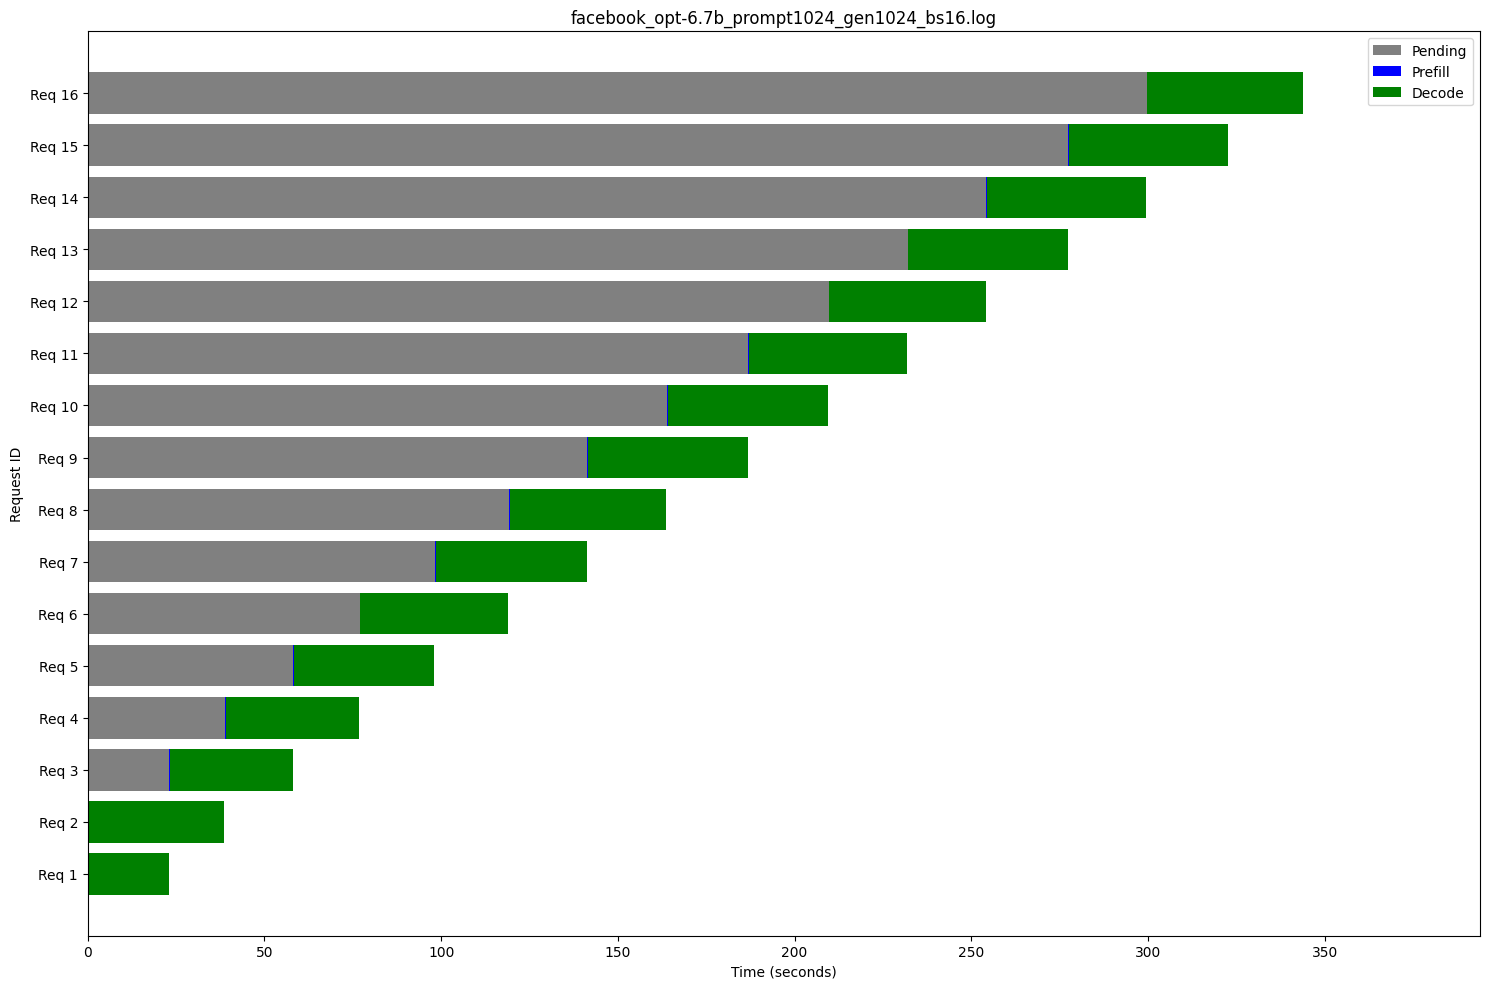

In [37]:
file = "facebook_opt-6.7b_prompt1024_gen1024_bs16.log"
draw_file(file)

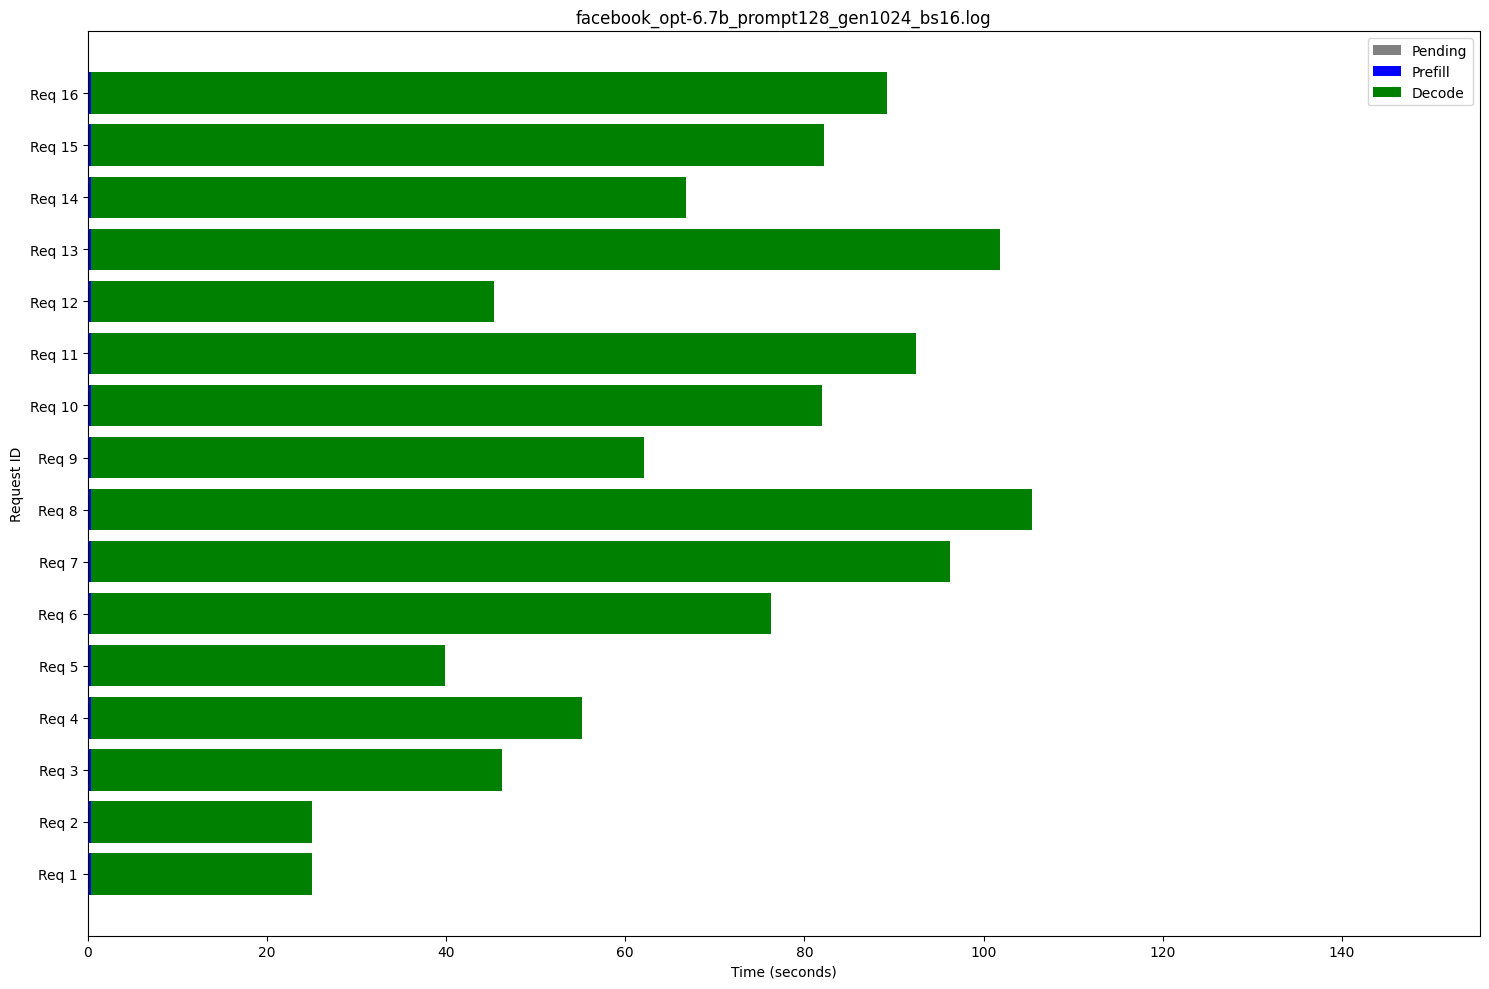

In [39]:
file = "facebook_opt-6.7b_prompt128_gen1024_bs16.log"
draw_file(file)

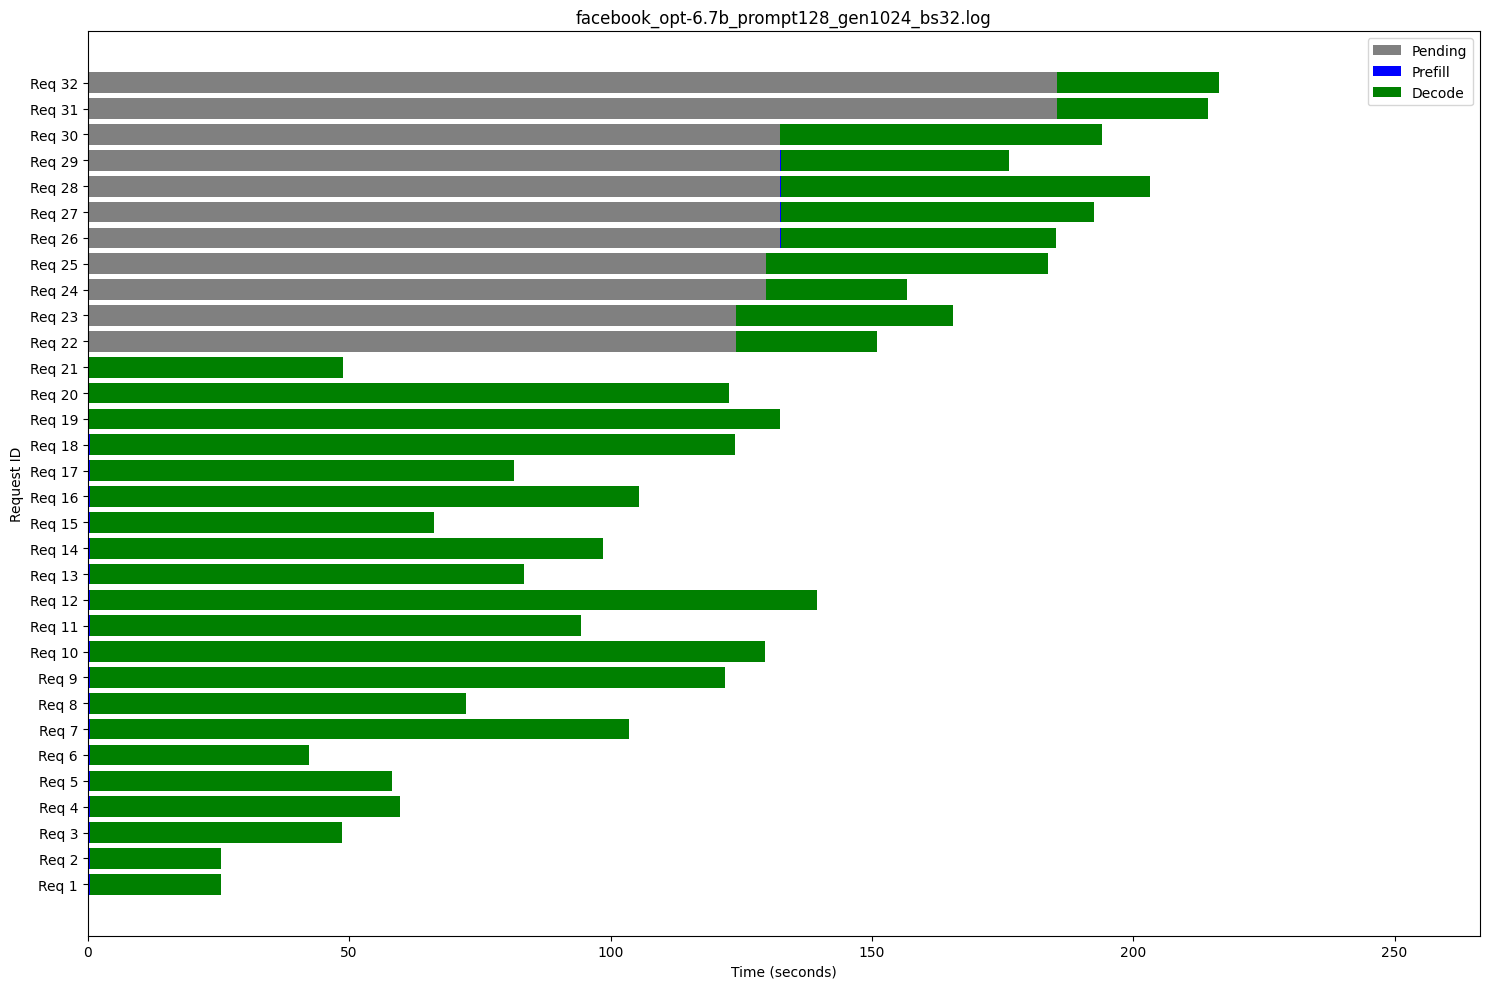

In [40]:
file = "facebook_opt-6.7b_prompt128_gen1024_bs32.log"
draw_file(file)

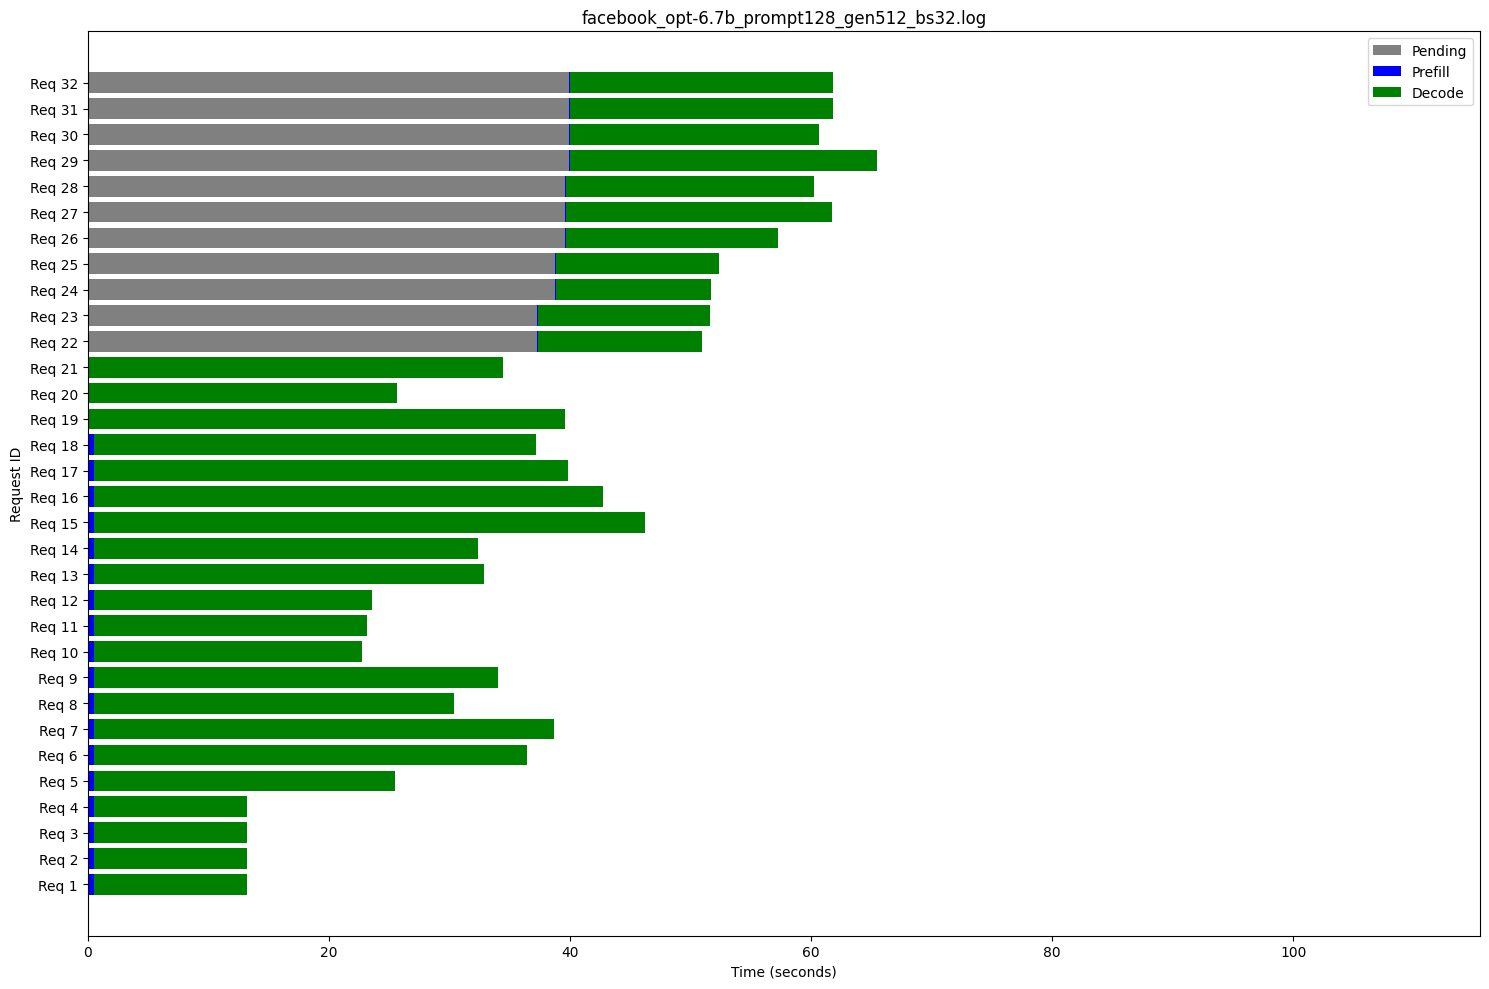

In [41]:
file = "facebook_opt-6.7b_prompt128_gen512_bs32.log"
draw_file(file)

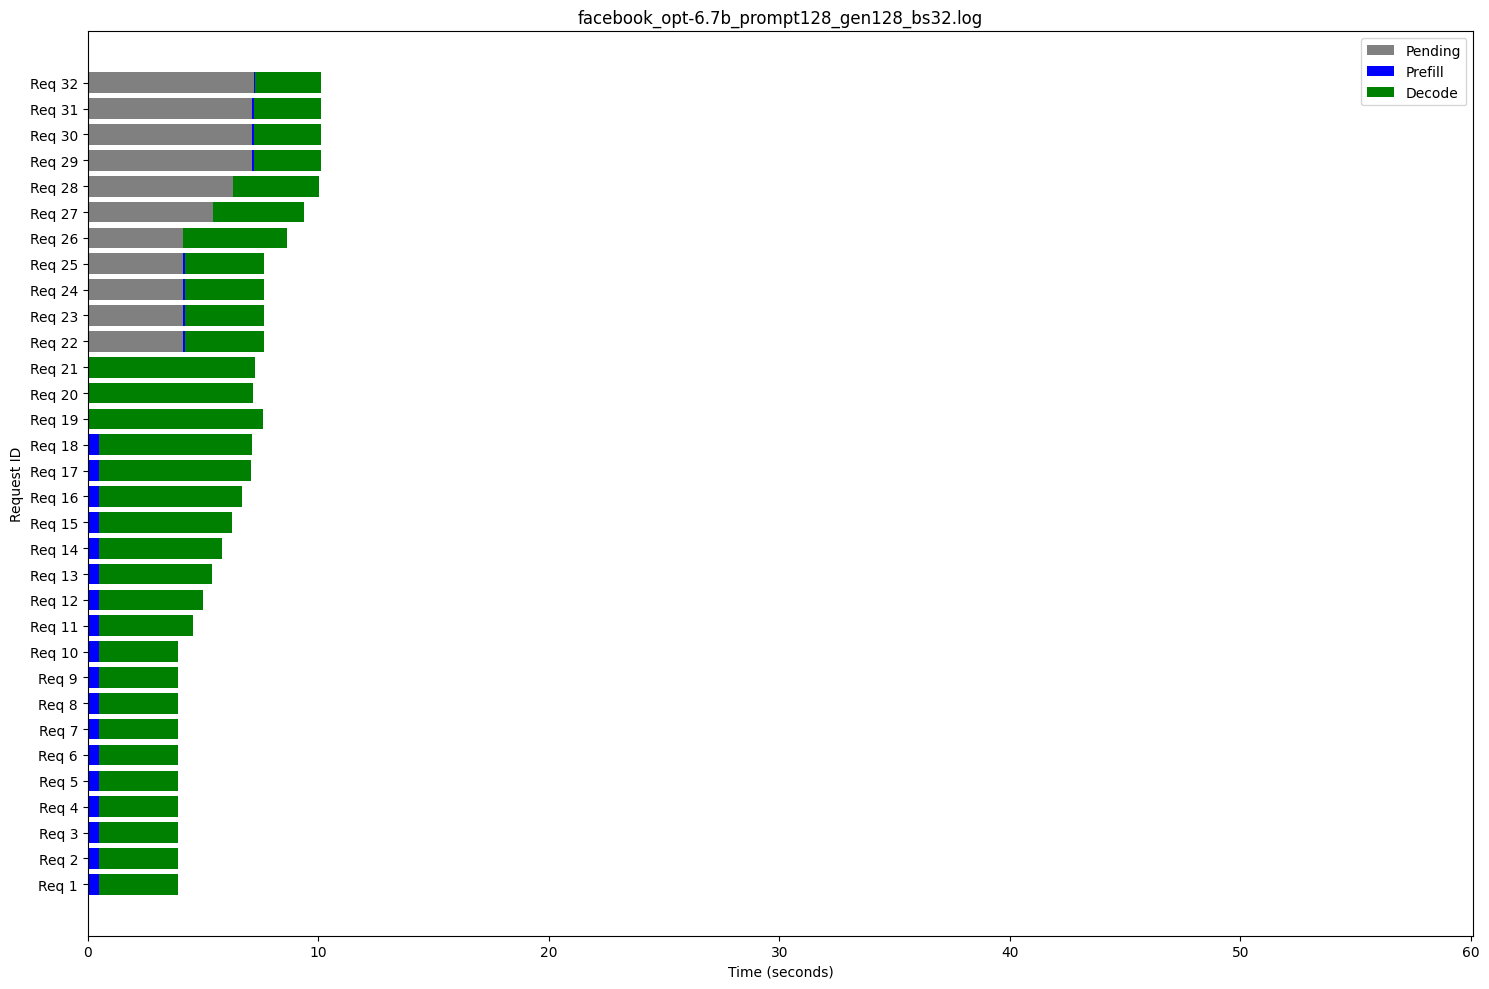

In [43]:
file = "facebook_opt-6.7b_prompt128_gen128_bs32.log"
draw_file(file)

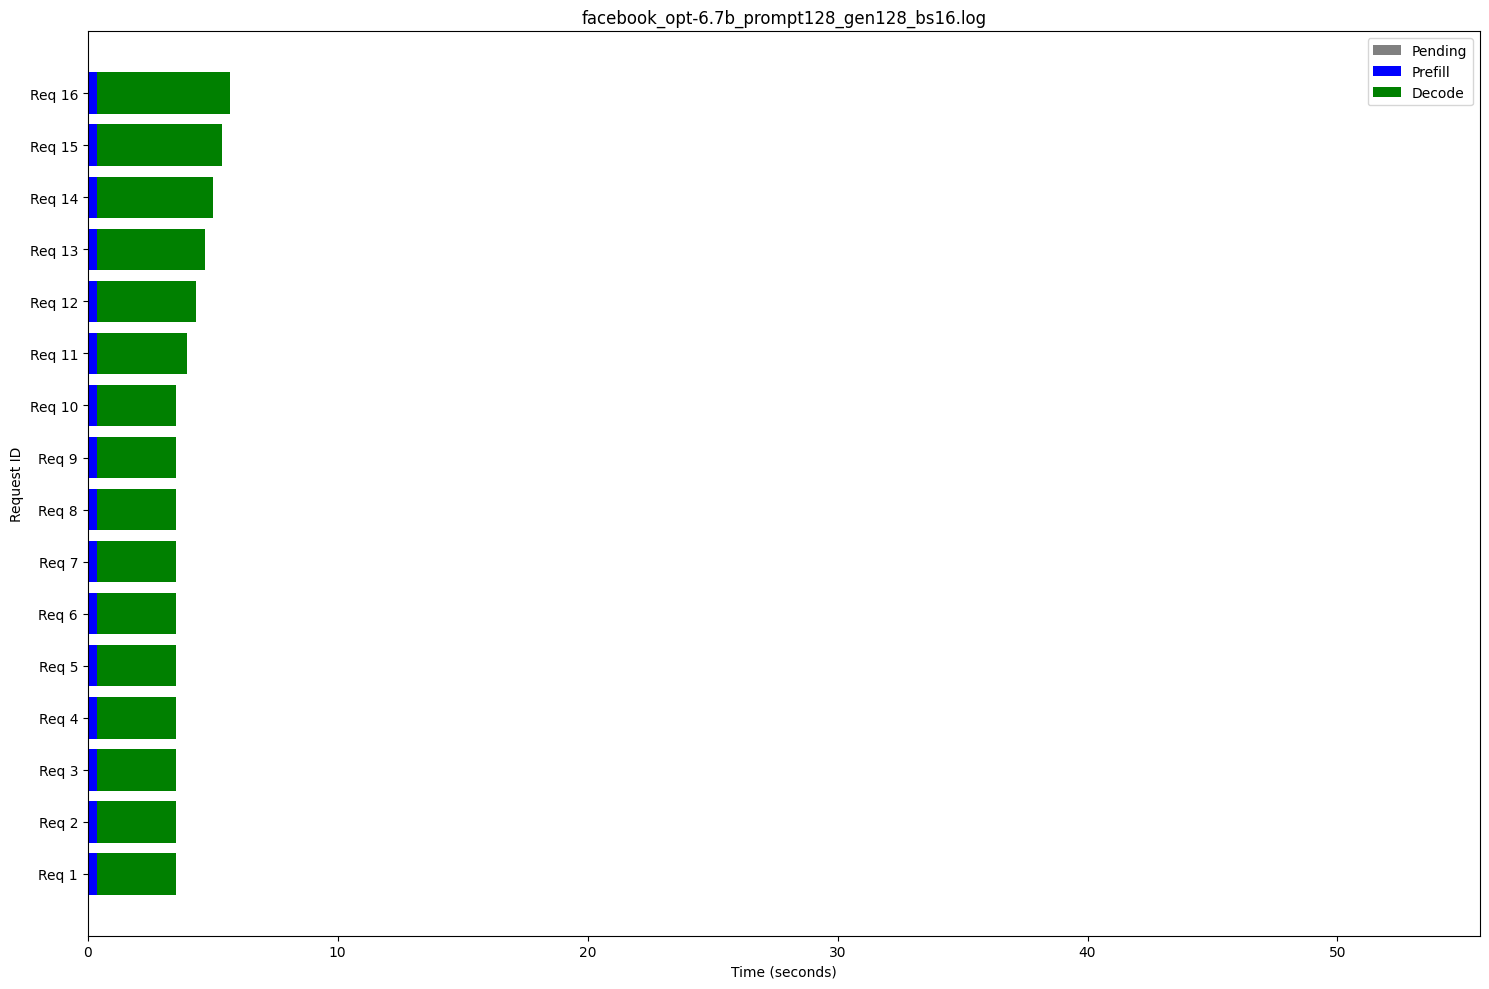

In [ ]:
file = "facebook_opt-6.7b_prompt128_gen128_bs16.log"
draw_file(file)

In [ ]:
file = "facebook_opt-6.7b_prompt128_gen1024_bs8.log"
draw_file(file)